NOTES
- profile of salinity width perhaps assume 50 m or 100 m wide??
- residence time is dependednt on M2 tidal component meaning every 12 hrs water moves 2 km, 0.1 m/sec


In [1]:
# IMport modules 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

# set options 
pd.set_option('display.max_rows', 6100)  

pd.set_option('mode.chained_assignment', None)

pd.options.display.float_format = '{:,.3f}'.format

In [2]:
!pip install geopandas
import geopandas as gpd

     |████████████████████████████████| 962kB 5.3MB/s 
     |████████████████████████████████| 10.9MB 10.1MB/s 
     |████████████████████████████████| 14.7MB 314kB/s 


In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

os.chdir('Shared drives/Attias_ER-to-SGD/Scripts')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


### Calculate salinity from conductivity function 

In [4]:
# from https://github.com/jsta/cond2sal_shiny/blob/master/helpers.R

def cond2sal(c, t = 25, P = 0):          # c in (uS/cm)
    a0 = 0.008
    a1 = -0.1692
    a2 = 25.3851
    a3 = 14.0941
    a4 = -7.0261
    a5 = 2.7081
    b0 = 5e-04
    b1 = -0.0056
    b2 = -0.0066
    b3 = -0.0375
    b4 = 0.0636
    b5 = -0.0144
    c0 = 0.6766097
    c1 = 0.0200564
    c2 = 0.0001104
    c3 = -6.9698e-07
    c4 = 1.0031e-09
    D1 = 0.03426
    D2 = 0.0004464
    D3 = 0.4215
    D4 = -0.003107
    e1 = 0.000207
    e2 = -6.37e-08
    e3 = 3.989e-12
    Csw = 42.914
    K = 0.0162
    
    Ct = round(c * (1 + 0.0191 * (t - 25)), 0)
    R = (Ct/1000)/Csw
    rt = c0 + (t * c1) + (t**2 * c2) + (t**3 * c3) + (t**4 * c4)
    Rp = 1 + (P * e1 + e2 * P**2 + e3 * P**3)/(1 + D1 * t + D2 * t**2 + (D3 + D4 * t) * R)
    Rt1 = R/(Rp * rt)
    dS = (b0 + b1 * Rt1**(1/2) + b2 * Rt1**(2/2) + b3 * Rt1**(3/2) + b4 * Rt1**(4/2) + b5 * Rt1**(5/2)) * (t - 15)/(1 + K * (t - 15))
    S = a0 + a1 * Rt1**(1/2) + a2 * Rt1**(2/2) + a3 * Rt1**(3/2) + a4 * Rt1**(4/2) + a5 * Rt1**(5/2) + dS
    
    return(S)

### Calculate conductivity from resistivity function

##### Note that 

 - Dataset OHM-m range 28.935 to 0.10685   
 - seawater has conductivity of around 54000 µS/cm
 
- ohmM_to_uSpcm(0.10685 ) = 93589.
- and 
- ohmM_to_uSpcm(28.935) =  345.6 
    
#### unit conversions notes
1 ohm-m = 1 S/m  
1 S/m = 10000 uS/cm

https://www.cactus2000.de/uk/unit/masscnd.php
https://www.translatorscafe.com/unit-converter/en-US/electric-conductivity/12-10/microsiemens/meter-millisiemens/meter/

http://salinometry.com/pss-78/

In [5]:
def ohmM_to_uSpcm(ohmMs):
    
    SiemensPerMeter = (1/ohmMs)
    uSpcm = SiemensPerMeter*10000
    
    return uSpcm

# Data Paths

In [6]:
# paths to data
datapath =  os.path.join("..", "Raw_Data", "Freshwater_Plumes_lines_information_for_Chris")
bathydata_path = os.path.join(datapath, 'Bathymetrylines_raw')

# path to the temp folder
workspace = os.path.join("..", 'Workspace')

# Some containers to house results

In [7]:
profile_name_list = []
Tot_vol_FW_1m_rez_list = []
pct_FW_list = []
Notes_List =[]

## Functions to perform various analysis tasks

In [13]:
# Read in resistivity profile Funciton

def Read_in_resistivity_profile(data_in):

    data = data_in.copy()

    # Convert the resistivity into conductivity and salinity
    data['Salinity'] = data['Resistivity'].apply(lambda x: cond2sal(ohmM_to_uSpcm(x)))
    data['Conductivity_uSpcm'] = data['Resistivity'].apply(lambda x: ohmM_to_uSpcm(x))

    # calculate the x-distance which is the distance along a profile starting at the first easting/northing point
    StartX = data['E'][0]
    StartY = data['N'][0]
    data["Xdistance"] = np.sqrt((data["E"]-StartX)**2 + (data["N"]-StartY)**2)

    # Also create a rounded version to use for tacking on bathymetry data
    data['Xdistance_int'] = data['Xdistance'].apply(lambda x: round(x))

    # If the depths are not negative numbers, make them be negative
    data['D'] =  data['D']*-1

    # Plot the whole profile as a scatter plot to look see
    fig, ax = plt.subplots(figsize =(10,5))
    plt.scatter(data['Xdistance'], data['D'], c=data['Conductivity_uSpcm'], cmap=plt.cm.jet, label=plt.cm.jet )
    plt.legend()

    return data

In [14]:
# Read in bathymetry profile Functon 

def Tack_on_Bathydata(profile_data_in, bathymetry_data_in):

    bathydata = bathymetry_data_in.copy()

    #bathydata = bathydata.reset_index()
    bathydata['Tot_Distance'] = bathydata['distance']-bathydata['distance'][0]
    bathydata['Tot_Distance_int'] = bathydata['Tot_Distance'].apply(lambda x: round(x))

    bathydata_interpolate = pd.DataFrame({'Tot_Distance_int':list(range(0,bathydata['Tot_Distance_int'].max()))})
    bathydata_interpolate = bathydata_interpolate.merge(bathydata, on='Tot_Distance_int', how='outer')                                                                    

    bathydata_interpolate = bathydata_interpolate.interpolate()
    bathydata_interpolate = bathydata_interpolate.rename(columns={'Tot_Distance_int': 'Xdistance_int'})

    profile_data_in = profile_data_in.merge(bathydata_interpolate, on='Xdistance_int', how="left")

    data_bath = profile_data_in.copy()

    data_bath= data_bath[data_bath['floor Depth']*-1 < data_bath['D']]
    fig, ax = plt.subplots(figsize =(10,5))
    plt.scatter(data_bath['Xdistance'], data_bath['D'], c=data_bath['Conductivity_uSpcm'], cmap=plt.cm.jet, label=plt.cm.jet )

    return data_bath

# Note Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739 so just using the start value here 

In [18]:
def Calc_fractions_in_plume(data, cell_height):

    """
    function to take a resistivity profile and calc the % of fresh vs saltwater
    """

    data4 = data.copy()
    data5 = pd.DataFrame()    # create empty DF to house final DF

    startdist = data4['Xdistance'].min()
    data4['datumXdistance'] = data4['Xdistance'] + (-startdist)

    data4["cell_height"] = cell_height   # each cell seems to be 2 m high
 
    for i in data4['D'].unique():           # For each "row" of depth values
        tempframe = data4[data4['D'] == i]  # 
        tempframe.reset_index(inplace=True, drop=True) 

        tempframe['dA'] = abs(tempframe['datumXdistance'].shift(-1) - tempframe['datumXdistance'])/2 # distance between point and the last one then over 2 to calc dist from point to cell edge
        tempframe['dB'] = abs(tempframe['datumXdistance'].shift(1) - tempframe['datumXdistance'])/2  # distance between point and the next one then over 2 to calc dist from point to cell edge
        tempframe['cell_width'] = tempframe['dA']+tempframe['dB']

        data5 = pd.concat([data5,tempframe])

    # Calculate profile volumes 
    data5['cell_unit_area'] =data5['cell_height'] * data5['cell_width']
    data5['cell_FW_fraction'] = 1-data5['Salinity']/35    #  35 is salinity of ocean
    data5['cell_FW_volume_m3'] = data5['cell_FW_fraction']*data5['cell_unit_area']

    TOT_FW_Vol_m3 =  data5['cell_FW_volume_m3'].sum()
    TOT_profile_Vol_m3 =  data5['cell_unit_area'].sum()
    pct_FW = TOT_FW_Vol_m3/TOT_profile_Vol_m3*100
    Sanity_check_Pro_vol = data5['Xdistance'].max()  * abs(data5['D']).max()

    print("\n  total volume of FW in profile is {:,.1f}".format(TOT_FW_Vol_m3))
    print("\n  tot profile vol. is  {:,.1f}".format(TOT_profile_Vol_m3))
    print("      Also to sanity check tot profile Vol the LxW of profile is {:,.1f}".format(Sanity_check_Pro_vol))
    print("\n  Thus % of FW in profile is {:,.1f}% \n".format( pct_FW))
    
    return data5, TOT_profile_Vol_m3, pct_FW

# Execute On data Profiles

# A: Execute analysis on 3.Line3aSegment2MainPlume


Percent of data that is unrealistically high salinity 14.87%
Percent of data that is salinity < 1 is 1.67%

  total volume of FW in profile is 91867.2

  tot profile vol. is  204131.7
      Also to sanity check tot profile Vol the LxW of profile is 215,959.8

  Thus % of FW in profile is 45.0% 



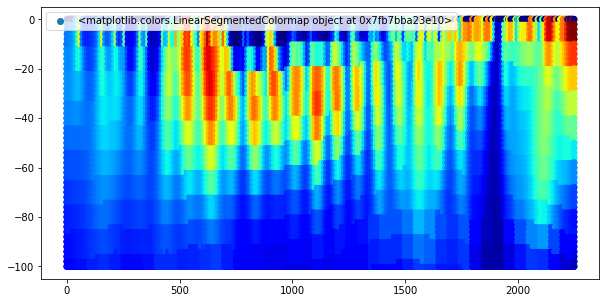

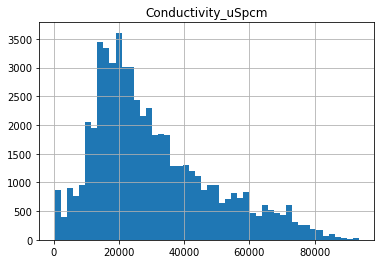

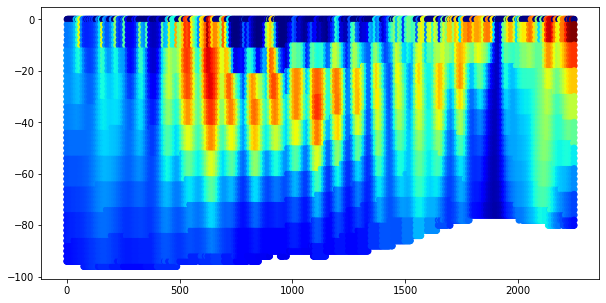

In [17]:
# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(datapath, '3.Line3aSegment2MainPlume', "Line3a_Segment2.txt"), 
                   sep = " ", index_col=False)
# Execute function above
data1 = Read_in_resistivity_profile(data_L3aS2)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)



# Step 2: Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 2_bathy.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data1, bathydata_in)



# Step 3: sanity checks and fix over salinity values
# Check how much of the resistiviy value if directly translated to conductivity are of an unrealistic value
Unrealistic_hi = data_bath[data_bath['Conductivity_uSpcm'] >54000]
print("Percent of data that is unrealistically high salinity {:.2f}%".format(100*len(Unrealistic_hi)/len(data_bath)))

# Check how much of the resistiviy value if directly translated to a salinity of of a kind of crazy value to be in the ocean
Very_low = data_bath[data_bath['Salinity'] < 1]
print("Percent of data that is salinity < 1 is {:.2f}%".format(100*len(Very_low)/len(data_bath)))

# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity'] > 35, 'Salinity'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)

# Step 5:  save resulting points as shapefiles
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3a_Segment2_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Append Results 
profile_name_list.append("Line3a_Segment2_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739")



In [20]:
data5_Corrected['cell_unit_area'].describe()

count   50,581.000
mean         4.036
std          3.206
min          2.827
25%          3.555
50%          4.241
75%          4.241
max        438.591
Name: cell_unit_area, dtype: float64

# B: Execute analysis on 3.Line3aSegment2MainPlume - just little plume part

Percent of data that is unrealistically high salinity 11.20%
Percent of data that is salinity < 1 is 1.39%

  total volume of FW in profile is 12,930.8

  tot profile vol. is  24,928.5
      Also to sanity check tot profile Vol the LxW of profile is 162,223.1

  Thus % of FW in profile is 51.9% 



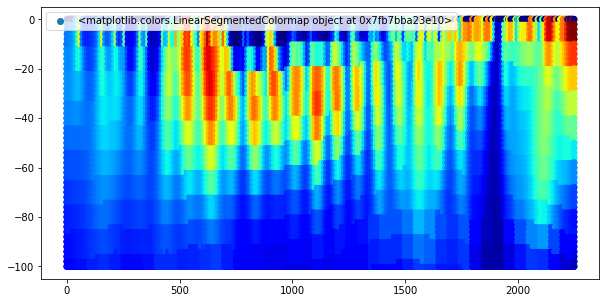

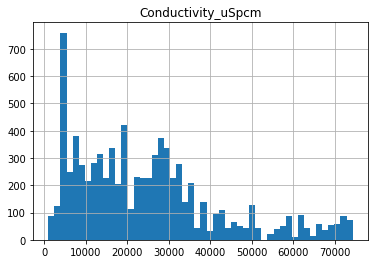

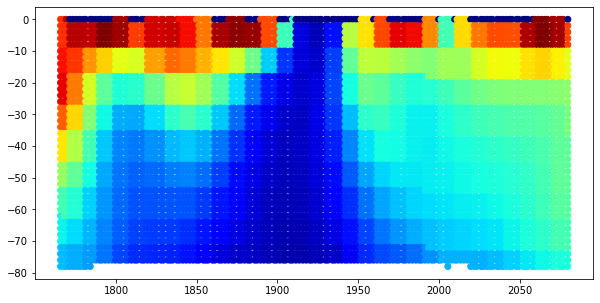

In [21]:
# Step 1: Read in data 
data_L3aS2 = pd.read_csv(os.path.join(datapath, '3.Line3aSegment2MainPlume', "Line3a_Segment2.txt"), 
                   sep = " ", index_col=False)
# Execute function above
data1 = Read_in_resistivity_profile(data_L3aS2)


# zoom in on a specfic part of the profile
data_plume = data1.copy()
data_plume = data_plume[(data_plume['Xdistance'] > 1765) & (data_plume['Xdistance'] < 2080) ]



# Check out histogram of data
data_plume.hist(column='Conductivity_uSpcm', bins=50)

# Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 2_bathy.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data_plume, bathydata_in)


# Check how much of the resistiviy value if directly translated to conductivity are of an unrealistic value
Unrealistic_hi = data_bath[data_bath['Conductivity_uSpcm'] >54000]
print("Percent of data that is unrealistically high salinity {:.2f}%".format(100*len(Unrealistic_hi)/len(data_bath)))

# Check how much of the resistiviy value if directly translated to a salinity of of a kind of crazy value to be in the ocean
Very_low = data_bath[data_bath['Salinity'] < 1]
print("Percent of data that is salinity < 1 is {:.2f}%".format(100*len(Very_low)/len(data_bath)))


# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity'] > 35, 'Salinity'] = 35


# Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW = Calc_fractions_in_plume(data_bath, 2)

# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3a_Segment2_Small_plume.shp"), driver='ESRI Shapefile')  #write shapefile

# Append Results 
profile_name_list.append("Line3a_Segment2_Small_plume.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Just the small plume, and Problem as the length of the bathymetry file seems to be 2998.983900, whereas the resistivity corss section is 2249.581739")

# C: Execute analysis on 2.Line3c_Section1

Percent of data that is unrealistically high salinity 24.83%
Percent of data that is salinity < 1 is 6.40%

  total volume of FW in profile is 28398.3

  tot profile vol. is  73901.8
      Also to sanity check tot profile Vol the LxW of profile is 70272.3572679898

  Thus % of FW in profile is 38.4% 



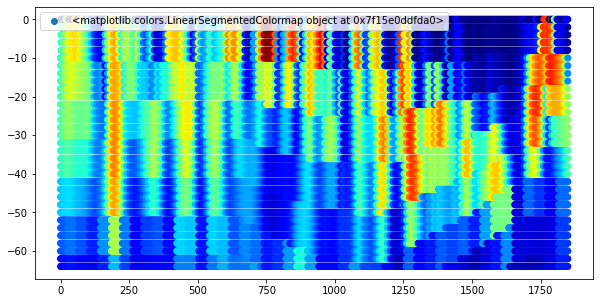

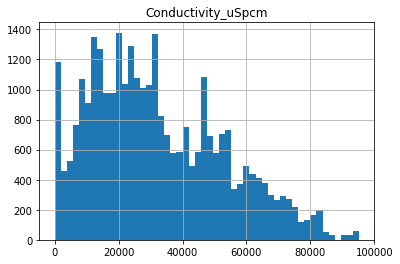

In [ ]:
# Step 1: Read in data 
data_L3cS1 = pd.read_csv(os.path.join(datapath, '2.Line3cSection1', "Line3c_Section1.txt"), 
                   sep = " ", index_col=False)

data1 = Read_in_resistivity_profile(data_L3cS1)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)


# Step 2: Read in bathydata and tack on data 
# Note: Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 40 m
data_bath = data1[data1["D"] > -40 ]



# Step 3: sanity checks and fix over salinity values
# Check how much of the resistiviy value if directly translated to conductivity are of an unrealistic value
Unrealistic_hi = data_bath[data_bath['Conductivity_uSpcm'] >54000]
print("Percent of data that is unrealistically high salinity {:.2f}%".format(100*len(Unrealistic_hi)/len(data_bath)))

# Check how much of the resistiviy value if directly translated to a salinity of of a kind of crazy value to be in the ocean
Very_low = data_bath[data_bath['Salinity'] < 1]
print("Percent of data that is salinity < 1 is {:.2f}%".format(100*len(Very_low)/len(data_bath)))

# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity'] > 35, 'Salinity'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)


# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "Line3c_Section1_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Append Results 
profile_name_list.append("Line3c_Section1_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 40 m")

# D: Execute analysis on 4. Line3a_Segment1

Percent of data that is unrealistically high salinity 11.50%
Percent of data that is salinity < 1 is 2.55%

  total volume of FW in profile is 76922.7

  tot profile vol. is  206595.3
      Also to sanity check tot profile Vol the LxW of profile is 202362.94569905827

  Thus % of FW in profile is 37.2% 



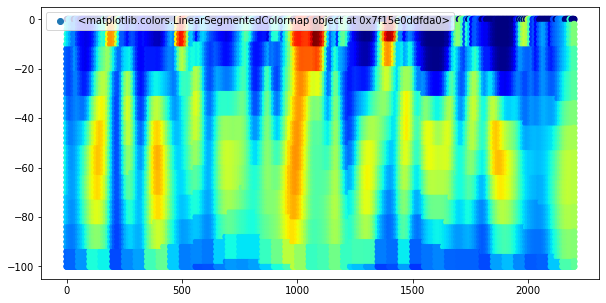

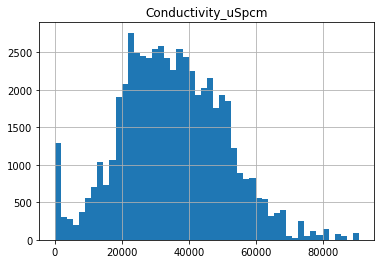

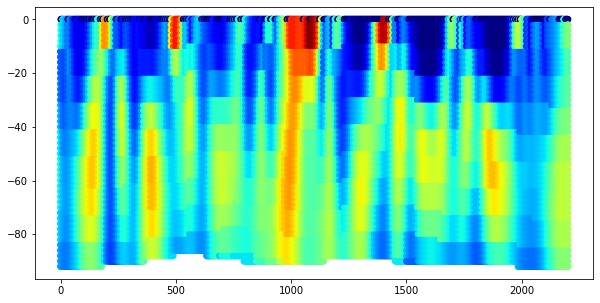

In [ ]:
# Step 1: Read in data 
data_4L3aS1 = pd.read_csv(os.path.join(datapath, '4.Line3aSegment1', "Line3a_Segment1.txt"), 
                   sep = " ", index_col=False)

data1 = Read_in_resistivity_profile(data_4L3aS1)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)


# Step 2: Read in bathydata and tack on data 
names = ["distance", "floor Depth"]
bathydata_in = pd.read_csv(os.path.join(bathydata_path, "Line3a_Segment 1 - CSEM_model_NOT_used_in_paper.txt"),
                        delim_whitespace=True, usecols=[0,1], names=names, skiprows=1, index_col=False)

data_bath = Tack_on_Bathydata(data1, bathydata_in)


# Step 3: sanity checks and fix over salinity values
# Check how much of the resistiviy value if directly translated to conductivity are of an unrealistic value
Unrealistic_hi = data_bath[data_bath['Conductivity_uSpcm'] >54000]
print("Percent of data that is unrealistically high salinity {:.2f}%".format(100*len(Unrealistic_hi)/len(data_bath)))

# Check how much of the resistiviy value if directly translated to a salinity of of a kind of crazy value to be in the ocean
Very_low = data_bath[data_bath['Salinity'] < 1]
print("Percent of data that is salinity < 1 is {:.2f}%".format(100*len(Very_low)/len(data_bath)))

# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity'] > 35, 'Salinity'] = 35


# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)

# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "4pLine3a_Segment 1_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Append Results 
profile_name_list.append("4pLine3a_Segment 1_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Apparently this one is not used in the paper")

# E: Execute analysis on  1.Line1 - Section 1

Percent of data that is unrealistically high salinity 1.23%
Percent of data that is salinity < 1 is 3.29%

  total volume of FW in profile is 42384.3

  tot profile vol. is  64949.5
      Also to sanity check tot profile Vol the LxW of profile is 60007.02678853535

  Thus % of FW in profile is 65.3% 



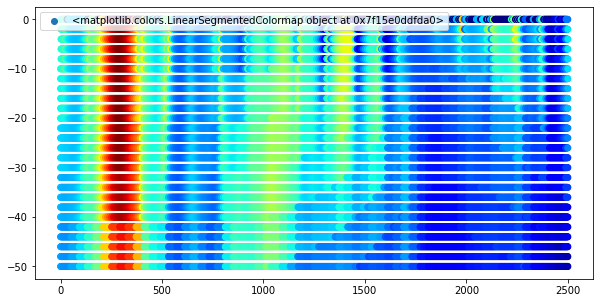

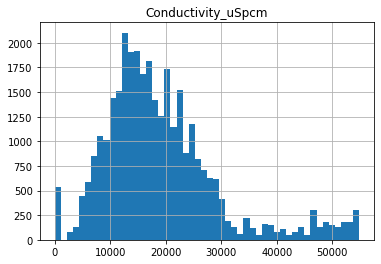

In [ ]:
# Step 1: Read in data 
data_1L1aS1 = pd.read_csv(os.path.join(datapath, '1.Line1 - Section 1', "Line1_Section1.txt"), 
                   sep = " ", index_col=False)

data1 = Read_in_resistivity_profile(data_1L1aS1)

# Check out histogram of data
data1.hist(column='Conductivity_uSpcm', bins=50)



# Step 2: Read in bathydata and tack on data 
# Note: Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 25 m
data_bath = data1[data1["D"] > -25 ]


# Step 3: sanity checks and fix over salinity values
# Check how much of the resistiviy value if directly translated to conductivity are of an unrealistic value
Unrealistic_hi = data_bath[data_bath['Conductivity_uSpcm'] >54000]
print("Percent of data that is unrealistically high salinity {:.2f}%".format(100*len(Unrealistic_hi)/len(data_bath)))

# Check how much of the resistiviy value if directly translated to a salinity of of a kind of crazy value to be in the ocean
Very_low = data_bath[data_bath['Salinity'] < 1]
print("Percent of data that is salinity < 1 is {:.2f}%".format(100*len(Very_low)/len(data_bath)))

# Replace out over salinity data values with max salinity 
data_bath.loc[data_bath['Salinity'] > 35, 'Salinity'] = 35

# Step 4:  Calculate the % of freshwater
data5_Corrected, TOT_profile_Vol_m3,  pct_FW  = Calc_fractions_in_plume(data_bath, 2)


# save resulting points as shapefile
LonCol = 'Xdistance'
LatCol = 'D'
GeoDF = gpd.GeoDataFrame(data5_Corrected, geometry=gpd.points_from_xy(data5_Corrected[LonCol], data5_Corrected[LatCol]))
GeoDF.to_file(os.path.join(workspace, 'Shapefiles', "4pLine3a_Segment 1_Profile.shp"), driver='ESRI Shapefile')  #write shapefile

# Append Results 
profile_name_list.append("4pLine3a_Segment 1_Profile.shp")
Tot_vol_FW_1m_rez_list.append(TOT_profile_Vol_m3) 
pct_FW_list.append(pct_FW)
Notes_List.append("Can not find corresponding bathymetry file for this profile. for now cutting off anything deeper than 25 m")

In [ ]:
# Compile results
Results_Frame = pd.DataFrame({"Profile":profile_name_list , "Total_FW_1m_UnitWidth_m3":Tot_vol_FW_1m_rez_list, "%FW_in_profile":pct_FW_list, "Notes":Notes_List})

# Set caclulation Parameters 

# Set residence time  (one day is very conservative)
Residence_time_days = 1

# Set assumed profile width  (50 to 100 m???)
Profile_width = 50


# Set up the flux calculations

Results_Frame['Tot_FW_VOL_Wide_Profile'] = Results_Frame['Total_FW_1m_UnitWidth']*Profile_width

Results_Frame['Profile_FLUX_m3pd'] = Results_Frame['Tot_FW_VOL_Wide_Profile']/Residence_time_days




Results_Frame

,Profile,Total_FW_1m_UnitWidth,%FW_in_profile,Notes,Tot_FW_VOL_Wide_Profile,Profile_FLUX_m3pd
0,Line3a_Segment2_Profile.shp,"408,263",45,Problem as the length of the bathymetry file s...,"20,413,173","20,413,173"
1,Line3a_Segment2_Small_plume.shp,"49,857",52,"Just the small plume, and Problem as the lengt...","2,492,846","2,492,846"
2,Line3c_Section1_Profile.shp,"147,804",38,Can not find corresponding bathymetry file for...,"7,390,176","7,390,176"
3,4pLine3a_Segment 1_Profile.shp,"413,191",37,Apparently this one is not used in the paper,"20,659,529","20,659,529"
4,4pLine3a_Segment 1_Profile.shp,"129,899",65,Can not find corresponding bathymetry file for...,"6,494,952","6,494,952"
